# Showing uncertainty
> Uncertainty occurs everywhere in data science, but it's frequently left out of visualizations where it should be included. Here, we review what a confidence interval is and how to visualize them for both single estimates and continuous functions. Additionally, we discuss the bootstrap resampling technique for assessing uncertainty and how to visualize it properly. This is the Summary of lecture "Improving Your Data Visualizations in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Visualization]
- image: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

### Point estimate intervals
- When is uncertainty important?
    - Estimates from sample
        - Average of a subset
        - Linear model coefficients
- Why is uncertainty important?
    - Helps inform confidence in estimate
    - Neccessary for decision making
    - Acknowledges limitations of data

### Basic confidence intervals
You are a data scientist for a fireworks manufacturer in Des Moines, Iowa. You need to make a case to the city that your company's large fireworks show has not caused any harm to the city's air. To do this, you look at the average levels for pollutants in the week after the fourth of July and how they compare to readings taken after your last show. By showing confidence intervals around the averages, you can make a case that the recent readings were well within the normal range.

In [5]:
average_ests = pd.read_csv('./dataset/average_ests.csv', index_col=0)
average_ests

,pollutant,mean,std_err,y,seen
0,CO,0.351911,0.033563,95% Interval,0.40
1,NO2,19.021429,2.200518,95% Interval,16.00
2,O3,0.043982,0.001822,95% Interval,0.05
3,SO2,0.207143,0.037518,95% Interval,0.15


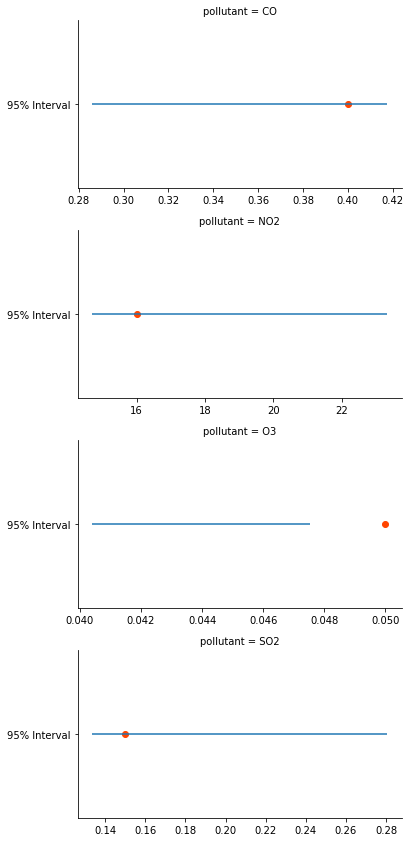

In [7]:
# Construct CI bounds for averages
average_ests['lower'] = average_ests['mean'] - 1.96 * average_ests['std_err']
average_ests['upper'] = average_ests['mean'] + 1.96 * average_ests['std_err']

# Setup a grid of plots, with non-shared x axes limits
g = sns.FacetGrid(average_ests, row='pollutant', sharex=False, aspect=2);

# Plot CI for average estimate
g.map(plt.hlines, 'y', 'lower', 'upper');

# Plot observed values for comparison and remove axes labels
g.map(plt.scatter, 'seen', 'y', color='orangered').set_ylabels('').set_xlabels('');

This simple visualization shows that all the observed values fall well within the confidence intervals for all the pollutants except for $O_3$.

### Annotating confidence intervals
Your data science work with pollution data is legendary, and you are now weighing job offers in both Cincinnati, Ohio and Indianapolis, Indiana. You want to see if the SO2 levels are significantly different in the two cities, and more specifically, which city has lower levels. To test this, you decide to look at the differences in the cities' SO2 values (Indianapolis' - Cincinnati's) over multiple years.

Instead of just displaying a p-value for a significant difference between the cities, you decide to look at the 95% confidence intervals (columns `lower` and `upper`) of the differences. This allows you to see the magnitude of the differences along with any trends over the years.

In [8]:
diffs_by_year = pd.read_csv('./dataset/diffs_by_year.csv', index_col=0)
diffs_by_year

,year,mean,std_err,lower,upper
0,2013,0.840820,0.870135,-0.864645,2.546284
1,2014,-1.337625,0.761541,-2.830245,0.154996
2,2015,-0.649327,0.618175,-1.860950,0.562295


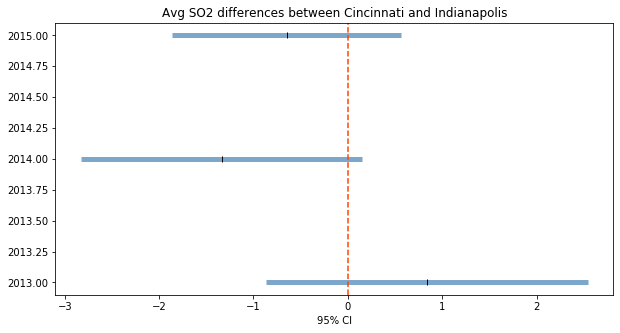

In [10]:
# Set start and ends according to intervals
# Make intervals thicker
plt.hlines(y='year', xmin='lower', xmax='upper', 
          linewidth=5, color='steelblue', alpha=0.7,
          data=diffs_by_year);

# Point estimates
plt.plot('mean', 'year', 'k|', data=diffs_by_year);

# Add a 'null' reference line at 0 and color orangered
plt.axvline(x=0, color='orangered', linestyle='--');

# Set descriptive axis labels and title
plt.xlabel('95% CI');
plt.title('Avg SO2 differences between Cincinnati and Indianapolis');

By looking at the confidence intervals you can see that the difference flipped from generally positive (more pollution in Cincinnati) in 2013 to negative (more pollution in Indianapolis) in 2014 and 2015. Given that every year's confidence interval contains the null value of zero, no P-Value would be significant, and a plot that only showed significance would have been entirely hidden this trend.

## Confidence bands

### Making a confidence band
Vandenberg Air Force Base is often used as a location to launch rockets into space. You have a theory that a recent increase in the pace of rocket launches could be harming the air quality in the surrounding region. To explore this, you plotted a 25-day rolling average line of the measurements of atmospheric $NO_2$. To help decide if any pattern observed is random-noise or not, you decide to add a 99% confidence band around your rolling mean. Adding a confidence band to a trend line can help shed light on the stability of the trend seen. This can either increase or decrease the confidence in the discovered trend.



In [12]:
vandenberg_NO2 = pd.read_csv('./dataset/vandenberg_NO2.csv', index_col=0)
vandenberg_NO2.head()

,day,mean,std_err
0,25,2.56,0.452831
1,26,2.44,0.452831
2,27,2.44,0.452831
3,28,2.44,0.452831
4,29,2.40,0.452548


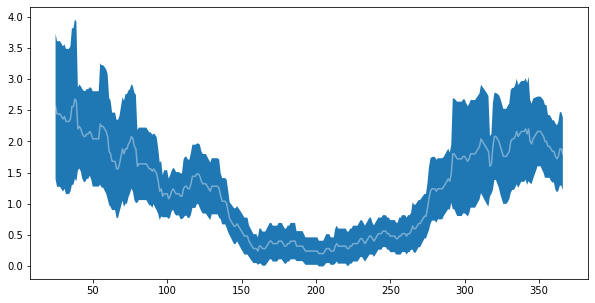

In [13]:
# Draw 99% interval bands for average NO2
vandenberg_NO2['lower'] = vandenberg_NO2['mean'] - 2.58 * vandenberg_NO2['std_err']
vandenberg_NO2['upper'] = vandenberg_NO2['mean'] + 2.58 * vandenberg_NO2['std_err']

# Plot mean estimate as a white semi-transparent line
plt.plot('day', 'mean', data=vandenberg_NO2, color='white', alpha=0.4);

# Fill between the upper and lower confidence band values
plt.fill_between(x='day', y1='lower', y2='upper', data=vandenberg_NO2);

This plot shows that the middle of the year's $NO_2$ values are not only lower than the beginning and end of the year but also are less noisy. If just the moving average line were plotted, then this potentially interesting observation would be completely missed. (Can you think of what may cause reduced variance at the lower values of the pollutant?)

### Separating a lot of bands
It is relatively simple to plot a bunch of trend lines on top of each other for rapid and precise comparisons. Unfortunately, if you need to add uncertainty bands around those lines, the plot becomes very difficult to read. Figuring out whether a line corresponds to the top of one class' band or the bottom of another's can be hard due to band overlap. Luckily in Seaborn, it's not difficult to break up the overlapping bands into separate faceted plots.

To see this, explore trends in SO2 levels for a few cities in the eastern half of the US. If you plot the trends and their confidence bands on a single plot - it's a mess. To fix, use Seaborn's `FacetGrid()` function to spread out the confidence intervals to multiple panes to ease your inspection.

In [14]:
eastern_SO2 = pd.read_csv('./dataset/eastern_SO2.csv', index_col=0)
eastern_SO2.head()

,city,day,mean,std_err,lower,upper
0,Cincinnati,24,8.5150,1.297358,5.972178,11.057822
1,Cincinnati,25,8.8825,1.277753,6.378104,11.386896
2,Cincinnati,26,8.9450,1.281322,6.433609,11.456391
3,Cincinnati,27,8.4775,1.317059,5.896065,11.058935
4,Cincinnati,28,9.2325,1.416357,6.456441,12.008559


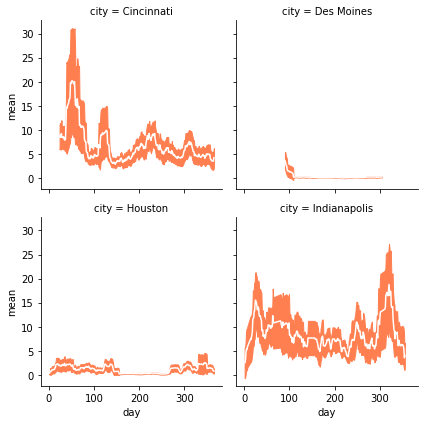

In [15]:
# setup a grid of plots with columns divided by location
g = sns.FacetGrid(eastern_SO2, col='city', col_wrap=2);

# Map interval plots to each cities data with coral colored ribbons
g.map(plt.fill_between, 'day', 'lower', 'upper', color='coral');

# Map overlaid mean plots with white line
g.map(plt.plot, 'day', 'mean', color='white');

By separating each band into its own plot you can investigate each city with ease. Here, you see that Des Moines and Houston on average have lower SO2 values for the entire year than the two cities in the Midwest. Cincinnati has a high and variable peak near the beginning of the year but is generally more stable and lower than Indianapolis.

### Cleaning up bands for overlaps
